# Load data
### Link : https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?resource=download&select=True.csv

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn import set_config; set_config(display='diagram')
#from tensorflow.keras.preprocessing.text import Tokenizer
import string
import os

nltk.download('stopwords')
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

NameError: name 'nltk' is not defined

In [ ]:
data_path = './raw_data/'

fake = pd.read_csv(data_path +'Fake.csv')
true = pd.read_csv(data_path +'True.csv')

In [ ]:
fake.head()

# Preparing the data for preprocessing

In [9]:
# Creating True columns for both dataframes 1 for true and 0 for fake

true['true'] = 1
fake['true'] = 0

# Concatenate the two in one dataframe

data = pd.concat([fake, true])

# Reset the index
data.reset_index(drop = True, inplace = True)

In [10]:
# The data is balanced

data.true.value_counts() / len(data) *100

0    52.298543
1    47.701457
Name: true, dtype: float64

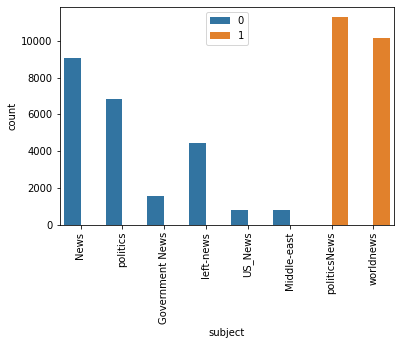

In [11]:
# Check true fake news along each subject
# From the chart we see that subject column isn't important so i'll drop it

sns.countplot(x = 'subject', hue = 'true', data = data)
plt.xticks(rotation = 'vertical')
plt.legend(loc = 'upper center');

In [12]:
# Merging text and title columns in one

data['text'] = data['title'] + " " + data['text']

# Creating a dataframe of text and true columns only (So after this point df is our dataframe)
df = data.loc[:, ['text', 'true']]

### Now, we have a dataframe that contains one feature 'text' and the target 'true', the next step is to clean the text column by removing puctuations, making all letters lower, removing digits, and strip from extra space.

# Preprocessing

In [13]:
def cleaning(sentence):
    
    # making all letters lower_case
    sentence = sentence.lower()
    
    # Removing numbers
    sentence = ''.join(char for char in sentence if not char.isdigit())
    
    # Removing punctuation
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '') 
    
    sentence = sentence.strip()
    
    return sentence

# Apply the function on the dataframe using pd.map

df['text'] = df['text'].map(cleaning)

In [18]:
# Only for Colab, remove after
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
# Tokenize texts and remove stop words
stop_words = set(stopwords.words('english')) 

def prep(sentence) :
    sentence = word_tokenize(sentence)
    sentence = [w for w in sentence if not w in stop_words]
    return sentence

df['text'] = df['text'].map(prep)

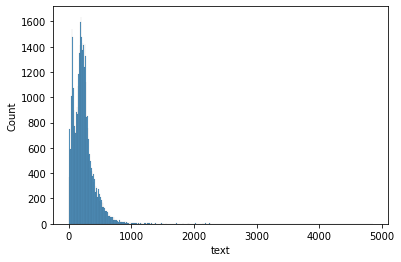

In [20]:
# Take a look at the length of each text
# Here for evey row i'm getting its length(how many words it contains)

sns.histplot(df['text'].map(lambda x : len(x)))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


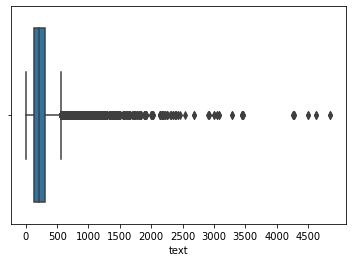

In [21]:
sns.boxplot(df['text'].map(lambda x : len(x)))
plt.xticks([i*500 for i in range(10)]);

## We can see that most of the data has less than 500 words, so to avoid large and useless padding i'll remove rows that contain more

In [22]:
# Create a column for the number of words in each row

df['num_words'] = df['text'].map(lambda x : len(x))

# Number of rows with more than 500 words is 3125

len(df[df['num_words'] > 500])

# Getting rid of rows that have more than 1000 words

df = df[df['num_words'] <= 500]

In [23]:
# Dropping the num_words columns because i just used it to filter out data with large number of words

del df['num_words']

In [ ]:
df.head()

 Up to this moment, we cleaned the data, so we have one feature 'text' which is a list of words and the target.
Now, i'll split the data into train and test, then i'll fit a tokenizer on the training set and transform training and testing sets. 

## Tokenization

In [24]:
# Splitting the data

X = df['text']             
y = df['true'] 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [25]:
# Initializing the tokenizer

tokenizer = Tokenizer()

# The tokenization learns a dictionary that maps a token (integer) to each word
# It can be done only on the train set - we are not supposed to know the test set!
# This tokenization also lowercases your words, apply some filters, and so on - you can check the doc if you want

tokenizer.fit_on_texts(X_train)

# We apply the tokenization to the train and test set

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [26]:
# Calculating the number of different words in the training set

vocab_size = len(tokenizer.word_index)

In [ ]:
vocab_size


## Padding to make the input of the same length

In [27]:
X_tr = pad_sequences(X_train_token, dtype='float32', padding='post')

X_te = pad_sequences(X_test_token, dtype='float32', padding='post')

# Creating our model

- Embedding layer whose input_dim is the size of your vocabulary + 1 to consider 0 that is added by padding, and whose output_dim is the size of the     embedding space you want to have
- RNN (SimpleRNN, LSTM, GRU) layer
- Dense layer
- Output layer

In [28]:
model = Sequential([
    layers.Embedding(
    input_dim=vocab_size+1,
    output_dim= 30,
    mask_zero=True, ),
    layers.LSTM(20),
    layers.Dense(10, activation = 'relu'),
    layers.Dense(1, activation="sigmoid")
    

])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [30]:
# Early stopping and train the model

es = EarlyStopping(patience = 4)

model.fit(X_tr, y_train, callbacks = [es], epochs = 2)

Epoch 1/2
914/914 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9808

914/914 [==============================] - 286s 312ms/step - loss: 0.0665 - accuracy: 0.9808
Epoch 2/2
914/914 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9935

914/914 [==============================] - 286s 313ms/step - loss: 0.0223 - accuracy: 0.9935


In [31]:
model.evaluate(X_te, y_test)

392/392 [==============================] - 25s 56ms/step - loss: 0.0268 - accuracy: 0.9921


[0.02680201269686222, 0.9921002388000488]